In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
 
import matplotlib.pyplot as plt
import pickle as p
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

In [2]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size, device='cpu'):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [3]:
# code taken from: https://github.com/JulesBelveze/time-series-autoencoder/blob/2c00b373ca422435ae56199ec964984df337c455/tsa/dataset.py#L8

class TimeSeriesDataset(object):
    def __init__(self, data, target_col, seq_length, prediction_window=1):
        '''
        :param data: dataset of type pandas.DataFrame
        :param categorical_cols: name of the categorical columns, if None pass empty list
        :param target_col: name of the targeted column
        :param seq_length: window length to use
        :param prediction_window: window length to predict
        '''
        self.data = data
        self.numerical_cols = list(set(data.columns) - set(target_col))
        self.target_col = target_col
        self.seq_length = seq_length
        self.prediction_window = prediction_window
        self.preprocessor = None

    def preprocess_data(self):
        '''Preprocessing function'''
        X = self.data.drop(self.target_col, axis=1)
        y = self.data[self.target_col]

        self.preprocessor = ColumnTransformer(
            [("scaler", StandardScaler(), self.numerical_cols),
             ],
            remainder="passthrough"
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
        X_train = self.preprocessor.fit_transform(X_train)
        X_test = self.preprocessor.transform(X_test)

        if self.target_col:
            return X_train, X_test, y_train.values, y_test.values
        return X_train, X_test

    def frame_series(self, X, y=None):
        '''
        Function used to prepare the data for time series prediction
        :param X: set of features
        :param y: targeted value to predict
        :return: TensorDataset
        '''
        nb_obs, nb_features = X.shape
        features, target, y_hist = [], [], []

        for i in range(1, nb_obs - self.seq_length - self.prediction_window):
            features.append(torch.FloatTensor(X[i:i + self.seq_length, :]).unsqueeze(0))
            # lagged output used for prediction
            y_hist.append(
                torch.FloatTensor(y[i - 1:i + self.seq_length - 1]).unsqueeze(0))

        features_var, y_hist_var = torch.cat(features), torch.cat(y_hist)

        if y is not None:
            for i in range(1, nb_obs - self.seq_length - self.prediction_window):
                target.append(
                    torch.FloatTensor(y[i + self.seq_length:i + self.seq_length + self.prediction_window]))
            target_var = torch.cat(target)
            return TensorDataset(features_var, y_hist_var, target_var)

        return TensorDataset(features_var)

    def get_loaders(self, batch_size: int):
        '''
        Preprocess and frame the dataset
        :param batch_size: batch size
        :return: DataLoaders associated to training and testing data
        '''
        X_train, X_test, y_train, y_test = self.preprocess_data()
        nb_features = X_train.shape[1]

        train_dataset = self.frame_series(X_train, y_train)
        test_dataset = self.frame_series(X_test, y_test)

        train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        return train_iter, test_iter, nb_features


In [4]:
def calculateRMSE(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))


def calculateMAE(y, y_pred):
    return mean_absolute_error(y, y_pred)

In [5]:

df = pd.read_csv('aaxj.us.txt', sep=',',
                 infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'],index_col='Date')



In [6]:
print(df)

              Open    High     Low   Close   Volume  OpenInt
Date                                                        
2008-08-15  44.886  44.886  44.886  44.886      112        0
2008-08-18  44.564  44.564  43.875  43.875    28497        0
2008-08-19  43.283  43.283  43.283  43.283      112        0
2008-08-20  43.918  43.918  43.892  43.892     4468        0
2008-08-22  44.097  44.097  44.017  44.071     4006        0
...            ...     ...     ...     ...      ...      ...
2017-11-06  75.900  76.530  75.890  76.530  1313730        0
2017-11-07  76.490  76.580  76.090  76.185  1627277        0
2017-11-08  76.370  76.590  76.290  76.570   681128        0
2017-11-09  76.040  76.200  75.580  76.110  1261567        0
2017-11-10  76.110  76.150  75.870  76.080   619687        0

[2325 rows x 6 columns]


In [7]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,4):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
        #print(df.iloc[:,j].unique())
droping_list_all

# filling nan with mean in any columns


# another sanity check to make sure that there are not more any nan
df.isnull().sum()

Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [8]:
## resampling of data over days
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


In [9]:

batch_size = 32
lookback_period = 12
prediction_window = 1
input_size = len(df.columns) - 1 

In [10]:
ts = TimeSeriesDataset(
    data=df,
    target_col=['Open'], # target column we want to predict
    seq_length=lookback_period, #look back period
    prediction_window=prediction_window 
)


In [11]:

train_iter, test_iter, nb_features = ts.get_loaders(batch_size=batch_size)

In [17]:
def train(train_loader, learn_rate, hidden_dim=32, EPOCHS=5, model_type="LSTM"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 3
    # Instantiating the models
    model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer"
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, _,label in train_loader:
            counter += 1
            
            h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            if counter%100 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
    return model, criterion

In [18]:
device = 'cpu'
lr = 0.001

gru_model, lossFn = train(train_iter, lr, EPOCHS=1000, model_type="Lstm")

Starting Training of Lstm model
Epoch 1/1000 Done, Total Loss: 2620.4723007469847
Epoch 2/1000 Done, Total Loss: 2496.19551059656
Epoch 3/1000 Done, Total Loss: 2416.572410181949
Epoch 4/1000 Done, Total Loss: 2348.518311617667
Epoch 5/1000 Done, Total Loss: 2285.054005405359
Epoch 6/1000 Done, Total Loss: 2224.4273692348547
Epoch 7/1000 Done, Total Loss: 2165.938486735026
Epoch 8/1000 Done, Total Loss: 2109.224405924479
Epoch 9/1000 Done, Total Loss: 2054.0628308747946
Epoch 10/1000 Done, Total Loss: 2000.3085519891035
Epoch 11/1000 Done, Total Loss: 1947.863157038103
Epoch 12/1000 Done, Total Loss: 1896.6477661132812
Epoch 13/1000 Done, Total Loss: 1846.6019206799958
Epoch 14/1000 Done, Total Loss: 1797.6713920727111
Epoch 15/1000 Done, Total Loss: 1749.8186961391516
Epoch 16/1000 Done, Total Loss: 1703.004942241468
Epoch 17/1000 Done, Total Loss: 1657.2017854389392
Epoch 18/1000 Done, Total Loss: 1612.3816603275768
Epoch 19/1000 Done, Total Loss: 1568.517474258155
Epoch 20/1000 Done

In [40]:
# TEST
gru_model.eval()

outputs = np.ndarray((32,))
targets = np.ndarray((32,))

for batch_idx, batch in enumerate(test_iter):
        feature, y_hist, target = batch
        
        h = gru_model.init_hidden(feature.shape[0]) #batch size
        
        out, h = gru_model(feature.to(device).float(), h)
        outputs = np.hstack((outputs, out.cpu().detach().numpy().reshape(-1)))
        targets = np.hstack((targets, target.numpy().reshape(-1)))
outputs = outputs[32:]
targets = targets[32:]
print('Test RMSE: %.3f' % calculateRMSE(outputs, targets))

Test RMSE: 15.284


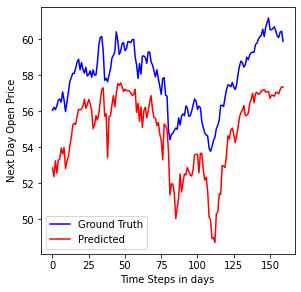

In [41]:
# Plot Range
plot_start, plot_end = 120, 280

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(targets[plot_start:plot_end], color="b", label="Ground Truth")
plt.plot(outputs[plot_start:plot_end],  color="r", label="Predicted")
plt.ylabel('Next Day Open Price')
plt.xlabel('Time Steps in days')
plt.legend()
plt.show()

In [42]:
def get_model_gradients(model, test_loader, loss_fn):

    model = model.train()

    grads = []

    h = model.init_hidden(batch_size)  # batch size

    for data, _, target in test_loader:

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output, _ = model(data.to(device).float(), h)

        # Calculate the loss
        loss = loss_fn(output.to(device).float(), target.to(device).float())

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Append to Grads
        grads.append(data_grad)

    target_grads = torch.cat(grads)

    return TensorDataset(target_grads)


In [44]:
def FGSM(model, test_iter, loss_fn, eps):
  adversarial_examples = np.ndarray((32, 12, 5))
  adversarial_predictions = np.ndarray((32, 1))
  grad_iter = get_model_gradients(model, test_iter, loss_fn)

  for i, data in enumerate(zip(test_iter, grad_iter)):
      h = gru_model.init_hidden(batch_size) #batch size
      adverserial_examples_batch = data[0][0] + eps * data[1][0].sign()
      pred, _ = gru_model(adverserial_examples_batch.to(device).float(), h)

      adversarial_examples = np.vstack((adversarial_examples, adverserial_examples_batch))
      adversarial_predictions = np.vstack((adversarial_predictions, pred.detach().cpu().numpy()))

  return adversarial_examples, adversarial_predictions

In [52]:
def BIM(model, test_iter, loss_fn, eps, nb_iter):
  adversarial_examples = np.ndarray((32, 12, 5))
  adversarial_predictions = np.ndarray((32, 1))
  adv_iter = test_iter

  for adverserial_examples_batch in test_iter:
    for j in range(nb_iter):
      grads= get_model_gradients(model, [adverserial_examples_batch], loss_fn)
      h = gru_model.init_hidden(batch_size) #batch size
      with torch.no_grad():
        adverserial_examples_batch[0] += eps/nb_iter * grads[0][0].sign()
        ae = adverserial_examples_batch[0]
        pred, _ = gru_model(ae.to(device).float(), h)
        if j == nb_iter -1:
          adversarial_examples = np.vstack((adversarial_examples, ae))
          adversarial_predictions = np.vstack((adversarial_predictions, pred.detach().cpu().numpy()))

  return adversarial_examples, adversarial_predictions

In [53]:
test = np.empty((32, 12, 5))
for t in test_iter:
  test = np.concatenate((test, t[0]))

In [55]:
adv_exp_fgsm, adv_prd_fgsm = FGSM(gru_model, test_iter, lossFn, eps=0.1)
adv_exp_bim, adv_prd_bim = BIM(gru_model, test_iter, lossFn, eps=0.1, nb_iter=100)
print('Test RMSE: %.3f' % calculateRMSE(outputs, targets))
print('FGSM RMSE: %.3f' % calculateRMSE(adv_prd_fgsm[:448], targets))
print('BIM RMSE: %.3f' % calculateRMSE(adv_prd_bim[:448], targets))

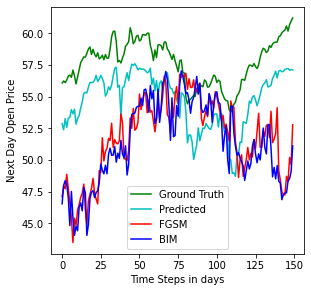

In [27]:
# Plot Range
plot_start, plot_end = 120, 270

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(targets[plot_start:plot_end],color="g", label="Ground Truth")
plt.plot(outputs[plot_start:plot_end], color="c", label="Predicted")
plt.plot(adv_prd_fgsm[plot_start:plot_end], color="r", label="FGSM")
plt.plot(adv_prd_bim[plot_start:plot_end], color="b", label="BIM")
plt.ylabel('Next Day Open Price')
plt.xlabel('Time Steps in days')
plt.legend()
plt.show()

In [71]:
adv_results = pd.DataFrame(index=['RMSE', 
                                  'Mean perturbed features   [Mean L0]', 
                                  'Max perturbed features    [Max  L0]', 
                                  'Mean Euclidiant distance  [Mean L2]', 
                                  'Max Euclidiant distance   [Max  L2]', 
                                  'Mean Maximum perturbation [Mean Li]', 
                                  'Max Maximum perturbation  [Max  Li]'])


def adv_norms(x_test_cpu, adversarial_examples_cpu):
    mean_l0 = np.mean(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    max_l0 = np.max(np.sum(x_test_cpu != adversarial_examples_cpu, axis=1))
    mean_l2 = np.mean(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    max_l2 = np.max(np.sum(np.power(x_test_cpu - adversarial_examples_cpu, 2), axis=1, keepdims=True))
    mean_li = np.mean(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    max_li = np.max(np.max(np.abs(x_test_cpu - adversarial_examples_cpu), axis=1, keepdims=True))
    return [mean_l0, max_l0, mean_l2, max_l2, mean_li, max_li]

In [73]:
adv_norms(test.reshape(28800, -1), adv_exp_fgsm.reshape(28800, -1))

[0.9996527777777777,
 1,
 0.00933342126117222,
 0.01000000476837215,
 0.09336143020766643,
 0.10000002384185791]